In [1]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py
import time

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import load_ml_data_emb
from data_manipulation.reading_util import load_non_enz_esm2


2023-09-14 18:34:51.884591: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 18:34:51.921572: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 18:34:51.922382: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 18:34:52.786915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Loading Embeddings and labeling

In [2]:
enzyme_csv_path = os.getenv("CSV50_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_50")

non_enzymes_esm2_path = os.getenv("ESM2_NON_ENZYMES")
non_enzymes_fasta_path = os.getenv("FASTA_NON_ENZYMES")


# Load enzymes
X_enzymes, y_enzymes = load_ml_data_emb(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)


# Load non_enzymes
X_non_enzymes, y_non_enzymes = load_non_enz_esm2(non_enzymes_fasta_path=non_enzymes_fasta_path,
                             non_enzymes_esm2_path=non_enzymes_esm2_path)




LOG: 4 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split50.csv
LOG: 35 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split50.csv
LOG: 561 multifunctional enzymes with diff ec main classes in  /home/malte/Desktop/Dataset/data/enzymes/csv/split50.csv
LOG: 600 entries will be ignored
LOG: Data loaded in: 3.195 min
LOG: ESM2 of enzymes: 28788
LOG: Labels of enzymes: 28788
LOG: 0 Sequences with aa O in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG: 17 Sequences with aa U in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG: 2138 non enzymes are longer than 1022 cutoff
LOG: 2155 entries will be ignored
LOG: Non Enzymes data loaded in: 4.316 min
LOG: ESM2 of non enzymes: 39502
LOG: Labels of non enzymes: 39502


## Append X_n and y_n to X and y:

In [3]:
X = np.vstack((X_enzymes, X_non_enzymes))
y = np.hstack((y_enzymes, y_non_enzymes))

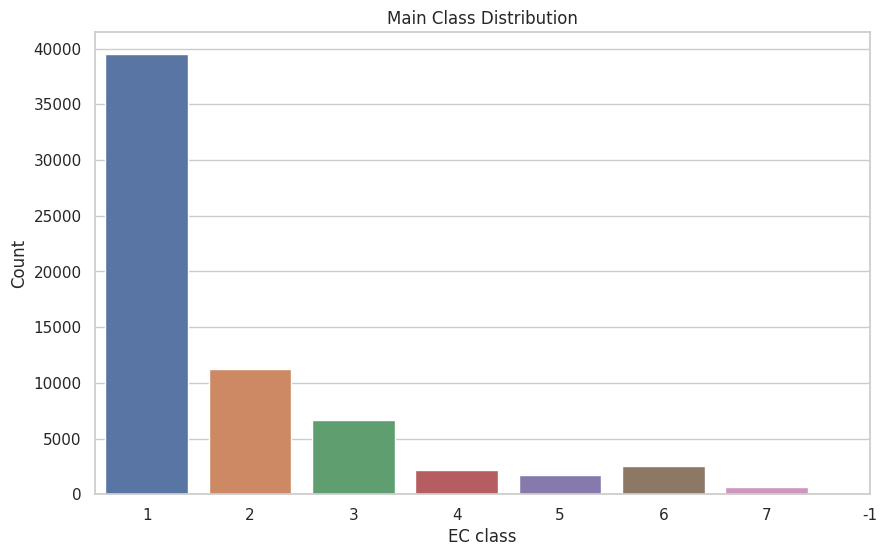

In [4]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y_enzymes)
sns.countplot(x=y_non_enzymes)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, -1])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Main Class Distribution")

# Show the plot
plt.show()


# Splitting data

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=8)
print(y_test_encoded[0])


[0. 1. 0. 0. 0. 0. 0. 0.]


# Creating CNN

In [9]:
# Initializing the model
model = tf.keras.models.Sequential()

earl_stop = tf.keras.callbacks.EarlyStopping(patience=5)

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=8, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Training CNN

In [10]:
model.fit(x=X_train, y=y_train_encoded, epochs=7, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/7


2023-09-13 16:57:56.154595: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1893744640 exceeds 10% of free system memory.


5777/5780 [============================>.] - ETA: 0s - loss: 0.4534

2023-09-13 16:58:55.216305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 811612160 exceeds 10% of free system memory.


5780/5780 [==============================] - 64s 11ms/step - loss: 0.4532 - val_loss: 0.1621
Epoch 2/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.2294 - val_loss: 0.1271
Epoch 3/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.1927 - val_loss: 0.1142
Epoch 4/7
5780/5780 [==============================] - 60s 10ms/step - loss: 0.1691 - val_loss: 0.1076
Epoch 5/7
5780/5780 [==============================] - 62s 11ms/step - loss: 0.1538 - val_loss: 0.0962
Epoch 6/7
5780/5780 [==============================] - 60s 10ms/step - loss: 0.1433 - val_loss: 0.0918
Epoch 7/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.1353 - val_loss: 0.0899


# Evaluation

<Figure size 1000x600 with 0 Axes>

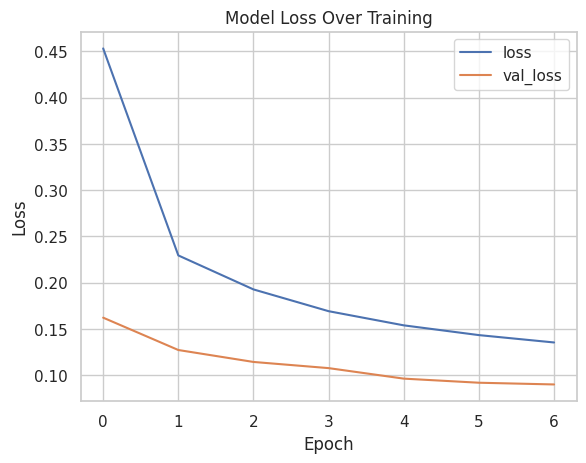

In [11]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
# for multi class classification (using softmax)
predictions = np.argmax(model.predict(X_test), axis=-1) 

  23/2477 [..............................] - ETA: 5s  

2023-09-13 17:05:13.291492: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 811612160 exceeds 10% of free system memory.


2477/2477 [==============================] - 6s 2ms/step


In [13]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  77319
Total samples predicted: 79259


In [14]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8311
           1       0.97      0.99      0.98     25021
           2       0.97      0.98      0.97     12490
           3       0.97      0.97      0.97      7011
           4       0.99      0.97      0.98      4332
           5       1.00      0.99      0.99      7789
           6       0.99      0.97      0.98      2426
           7       0.97      0.92      0.94     11879

    accuracy                           0.98     79259
   macro avg       0.98      0.97      0.98     79259
weighted avg       0.98      0.98      0.98     79259


In [4]:
def plot_report(report, y, predictions):
    """
    Plots results of model
    :param report: Report of model
    """

    class_0_metrics = report.split('\n')[2].split()[1:]
    class_1_metrics = report.split('\n')[3].split()[1:]
    class_2_metrics = report.split('\n')[4].split()[1:]
    class_3_metrics = report.split('\n')[5].split()[1:]
    class_4_metrics = report.split('\n')[6].split()[1:]
    class_5_metrics = report.split('\n')[7].split()[1:]
    class_6_metrics = report.split('\n')[8].split()[1:]
    class_7_metrics = report.split('\n')[9].split()[1:]

    metrics = [class_0_metrics,
               class_1_metrics,
               class_2_metrics,
               class_3_metrics,
               class_4_metrics,
               class_5_metrics,
               class_6_metrics,
               class_7_metrics
               ]

    precs = []
    recs = []
    f1_s = []

    for class_m in metrics:
        precision = float(class_m[0])
        recall = float(class_m[1])
        f1_score = float(class_m[2])
        precs.append(precision)
        recs.append(recall)
        f1_s.append(f1_score)

    class_names = [1, 2, 3, 4, 5, 6, 7, 0]

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_title("Recall")
    ax1.set_xlabel("Main Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_title("Precision")
    ax2.set_xlabel("Main Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("Main Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

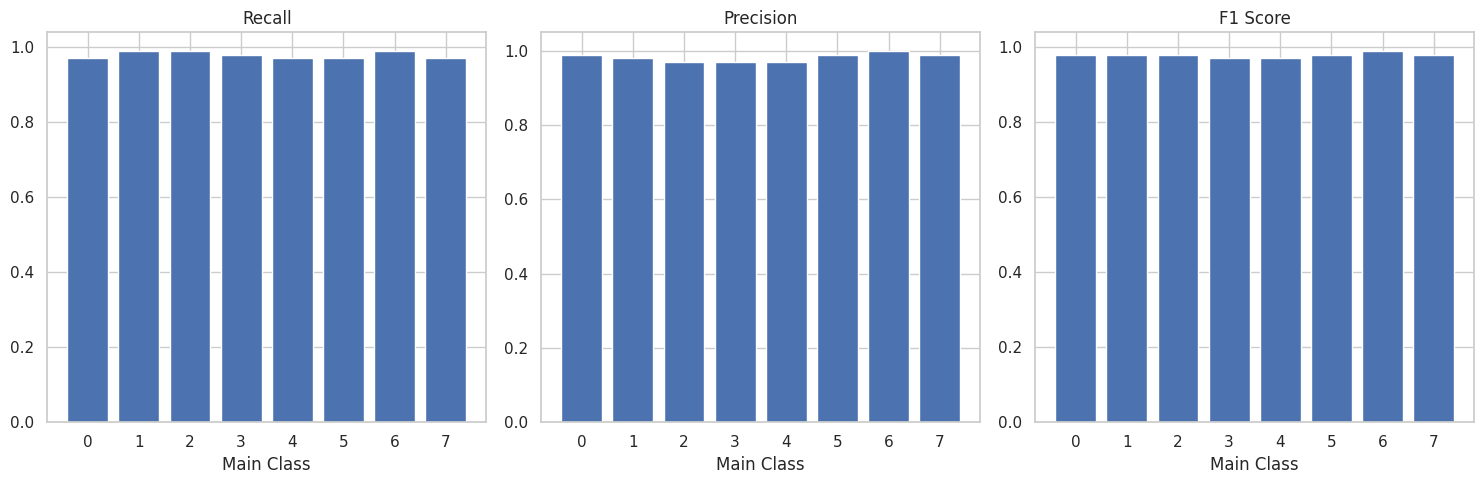

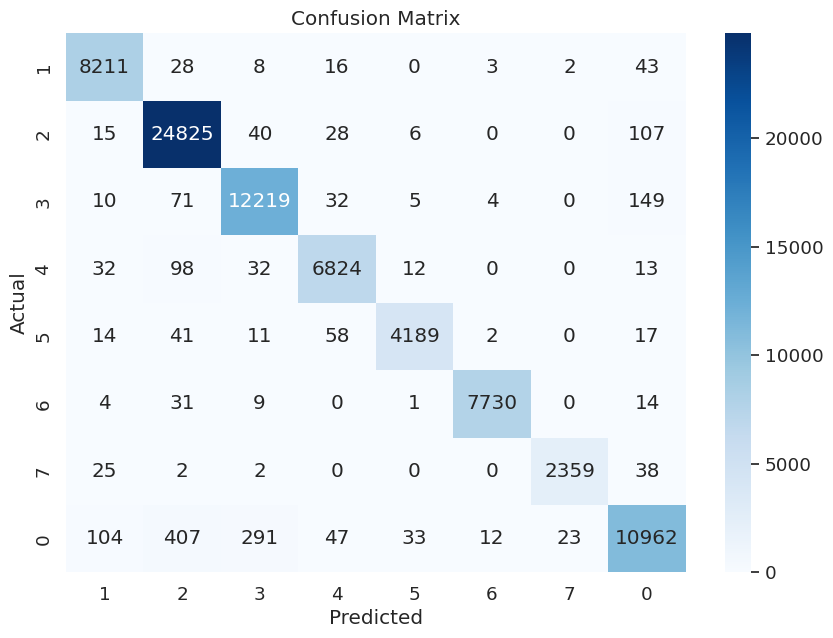

In [16]:
plot_report(report, y_test, predictions)

In [17]:
model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_v1_enz_non_enz_S100.keras")

# Testing Optuna for hyperparams

In [11]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 512)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 32, 256)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.7)
    num_units_dense_3 = trial.suggest_int('num_units_dense_3', 16, 128)
    
    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate_2))
    model.add(tf.keras.layers.Dense(units=num_units_dense_3, activation='relu'))
    model.add(tf.keras.layers.Dense(units=8, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=8)
    
    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=5)
    
    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=25, callbacks=[early_stop], verbose=0)
    
    # Get the best validation loss
    val_loss = min(history.history['val_loss'])
    
    return val_loss

In [6]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials as needed

[I 2023-09-14 18:42:28,343] A new study created in memory with name: no-name-8d56e212-dfd3-4753-ad86-ef772154db02
2023-09-14 18:42:28.836458: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 559431680 exceeds 10% of free system memory.
[I 2023-09-14 18:49:03,333] Trial 0 finished with value: 0.199890598654747 and parameters: {'num_units_dense_1': 323, 'dropout_rate_1': 0.23900844497528992, 'num_units_dense_2': 50, 'dropout_rate_2': 0.4827707359079015, 'num_units_dense_3': 104}. Best is trial 0 with value: 0.199890598654747.
2023-09-14 18:49:03.736212: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 559431680 exceeds 10% of free system memory.
[I 2023-09-14 18:51:44,856] Trial 1 finished with value: 0.23154471814632416 and parameters: {'num_units_dense_1': 314, 'dropout_rate_1': 0.00477150652264513, 'num_units_dense_2': 136, 'dropout_rate_2': 0.3765687864912021, 'num_units_dense_3': 96}. Best is trial 0 with value: 0.199890598654747.
2023-09-14 18:51

In [7]:
best_params = study.best_params
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']
best_dropout_rate_2 = best_params['dropout_rate_2']
best_num_units_dense_3 = best_params['num_units_dense_3']

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_2))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_3, activation='relu'))
final_model.add(tf.keras.layers.Dense(units=8, activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=8)

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

final_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=20, callbacks=[early_stop], verbose=1)

Epoch 1/20
1708/1708 [==============================] - 22s 13ms/step - loss: 0.6980 - accuracy: 0.7669 - val_loss: 0.3826 - val_accuracy: 0.8799
Epoch 2/20
1708/1708 [==============================] - 22s 13ms/step - loss: 0.4142 - accuracy: 0.8708 - val_loss: 0.3191 - val_accuracy: 0.9025
Epoch 3/20
1708/1708 [==============================] - 22s 13ms/step - loss: 0.3402 - accuracy: 0.8951 - val_loss: 0.2755 - val_accuracy: 0.9155
Epoch 4/20
1708/1708 [==============================] - 22s 13ms/step - loss: 0.3004 - accuracy: 0.9081 - val_loss: 0.2676 - val_accuracy: 0.9154
Epoch 5/20
1708/1708 [==============================] - 22s 13ms/step - loss: 0.2716 - accuracy: 0.9168 - val_loss: 0.2489 - val_accuracy: 0.9244
Epoch 6/20
1708/1708 [==============================] - 22s 13ms/step - loss: 0.2482 - accuracy: 0.9228 - val_loss: 0.2350 - val_accuracy: 0.9274
Epoch 7/20
1708/1708 [==============================] - 22s 13ms/step - loss: 0.2330 - accuracy: 0.9266 - val_loss: 0.2279 -

<Figure size 1000x600 with 0 Axes>

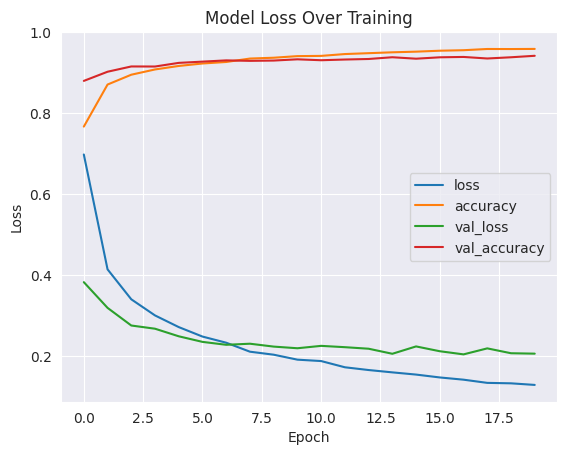

In [8]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [9]:
predictions = np.argmax(final_model.predict(X_val), axis=-1)

counter = 0
for x,y in zip(y_val,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_val))

427/427 [==============================] - 1s 2ms/step
Correct predictions:  12864
Total samples predicted: 13658


In [10]:
report = classification_report(y_val, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       765
           1       0.91      0.95      0.93      2226
           2       0.85      0.94      0.89      1261
           3       0.88      0.83      0.85       416
           4       0.94      0.92      0.93       347
           5       0.98      0.93      0.95       528
           6       0.95      0.82      0.88       125
           7       0.97      0.95      0.96      7990

    accuracy                           0.94     13658
   macro avg       0.92      0.91      0.91     13658
weighted avg       0.94      0.94      0.94     13658


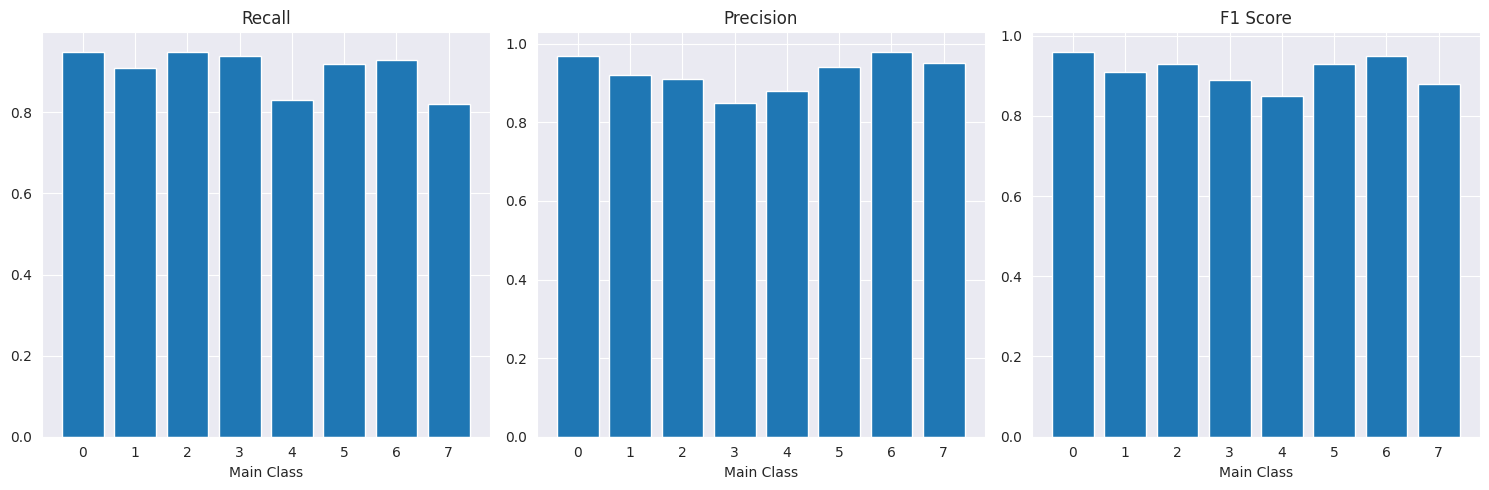

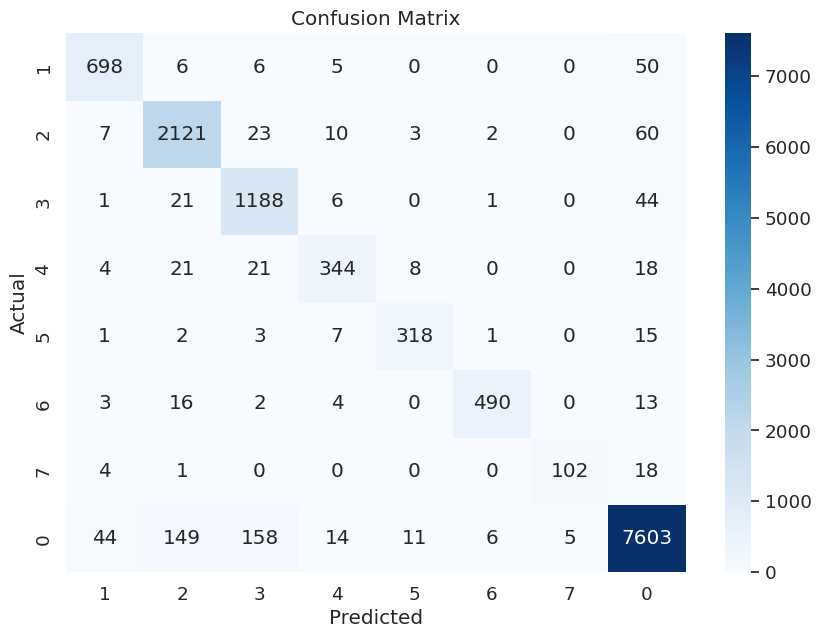

In [12]:
plot_report(report, y_val, predictions)

In [14]:
final_model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_opt_v1_enz_non_enz_S50.keras")
